# *Classifying facial expressions*

In [48]:
# Module imports
import numpy as np
import pandas as pd

# Various performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Various components of an ML pipeline
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# For feature engineering
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler

# And a few actual models
from sklearn.svm import LinearSVC

# plotting utilities
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [24]:
# Helper functions!
def load_features_and_labels(subject, expression, path = "./data/"):
    """ Reads the text files of raw data for a specified subject and
    expression.  Also removes the timestamp column and converts to
    numpy arrays for sklearn compatibility.
    """
    raw_features = pd.read_table(path + subject + "_" + expression + "_datapoints.txt",
                                 sep=" ",
                                 header=0)
    
    # Drop the timestamp!
    raw_features = raw_features.drop('0.0', axis=1)
    
    raw_labels = pd.read_table(path + subject + "_" + expression + "_targets.txt",
                               sep=" ",
                               header=None)
    
    # Trainsform to numpy arrays
    return np.asarray(raw_features), np.ravel(raw_labels)


def make_measurements(true, predicted):
    """ Make and report on lots of measurements of ML performance
    metrics.
    """
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    return("F1: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(f1, precision, recall))

In [53]:
# Code adapted from <https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html>
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# a & b)  Classify two expressions from subject A using "off the shelf" tech

NB;  Extra marks for coding my own implementation of the classifier

Initial SVM (rbf) parameters taken as suggested from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Use these classifiers to classify two expressions from subject B.

NB;  Extra marks for using something beyond simple accuracy (recycle ROC curve code?)

In [28]:
# This is the model we're going to use for sections a and b!
def setup_svc(cv=10,
              pipe_list = [('SVM', LinearSVC())],
              svc_parameters = {'SVM__C':np.logspace(-2, 10, 13)}):
    """ Helper function.  Lots of bits for setting up a grid-search
    for a linear SVM.
    """
    svc_pipeline = Pipeline(pipe_list)

    # Set up a cross-validated grid search
    svc_grid = GridSearchCV(svc_pipeline,                # tasks to perform
                            param_grid = svc_parameters, # parameters to try
                            cv=cv,                       # num cv folds
                            scoring='f1',                # score on f1
                            n_jobs=-1,                   # use all processors in parallel
                            verbose=True)
    
    return(svc_grid)

### Classifying "doubt" expression

This expression was chosen because in the original paper their own classification pipeline performed really well on it (f1 of 0.88 , precision of 0.94 and recall of 0.76 classifying single frames independently, engineered features WITHOUT depth features).

In [56]:
# Load and preprocess the data
X_A_doubt, y_A_doubt = load_features_and_labels("a", "doubt_question")
X_B_doubt, y_B_doubt = load_features_and_labels("b", "doubt_question")

In [57]:
# Model defined at start of section
svc_grid = setup_svc()

In [58]:
# Fit the model!
svc_grid.fit(X_A_doubt, y_A_doubt)

# Report on performance!
svc_grid.best_score_

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   38.7s finished


0.8584304666047529

In [63]:
# Report in some actually useful detail
y_A_doubt_pred = svc_grid.predict(X_A_doubt)
make_measurements(y_A_doubt, y_A_doubt_pred)

'F1: 0.57, precision: 1.00, recall: 0.40'

Confusion matrix, without normalization
[[821   0]
 [297 194]]


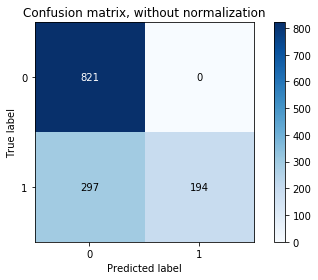

In [64]:
plot_confusion_matrix(y_A_doubt, y_A_doubt_pred)

### Predicting the "doubt" expression for subject B

In [65]:
# Report performance against unseen test data
y_test_pred = svc_grid.predict(X_B_doubt)
make_measurements(y_B_doubt, y_test_pred)

'F1: 0.75, precision: 0.63, recall: 0.93'

Confusion matrix, without normalization
[[296 421]
 [ 56 724]]


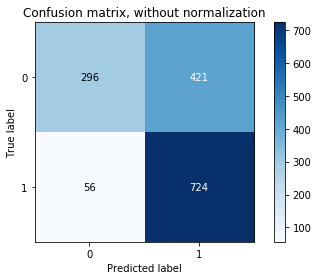

In [66]:
plot_confusion_matrix(y_B_doubt, y_test_pred)

### Classifying "negative" expression

The original author's model performed poorly on this one (f1 score of 0.44, precision of 0.33, recall of 0.66), so after the apparently easier problem of classifying doubt this should give us our relative performance on a hard problem.

In [67]:
# Load and preprocess the data
X_A_neg, y_A_neg = load_features_and_labels("a", "negative")
X_B_neg, y_B_neg = load_features_and_labels("b", "negative")

In [68]:
# model defined at start of section
svc_grid = setup_svc()

In [69]:
# Fit the model!
svc_grid.fit(X_A_neg, y_A_neg)

# Report on performance!
svc_grid.best_score_

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   35.7s finished


0.8351125839629964

In [70]:
# Report performance against unseen test data
y_A_neg_pred = svc_grid.predict(X_A_neg)
make_measurements(y_A_neg, y_A_neg_pred)

'F1: 0.10, precision: 1.00, recall: 0.05'

Confusion matrix, without normalization
[[596   0]
 [500  28]]


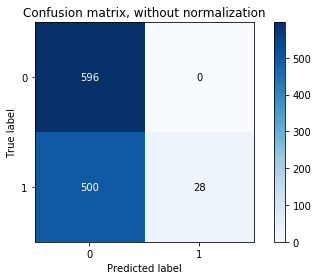

In [71]:
plot_confusion_matrix(y_A_neg, y_A_neg_pred)

### Predicting the "negative" expression for subject B

In [72]:
# Report performance against unseen test data
y_B_neg_pred = svc_grid.predict(X_B_neg)
make_measurements(y_B_neg, y_B_neg_pred)

'F1: 0.01, precision: 0.67, recall: 0.00'

Confusion matrix, without normalization
[[869   1]
 [710   2]]


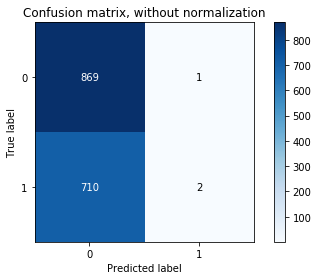

In [73]:
plot_confusion_matrix(y_B_neg, y_B_neg_pred)

# c)  Additional Analysis of classifiers - reverse roles!
Train on B, classify A, comment on difference!
Try again using a different feature representation (eg; PCA.  Can I think of something better?)

# d)  Implement a different classifier
Training on single expression, testing (on B?) and extra marks for own implementation
Training and testing on a SECOND expression
The same by inverting roles
Repeating with a different feature representation again!  
REF;  for last, try multiclass classifier on principle there should be some shared information?  Data imbalance problem

# e)  Wrap-up, compare results of the two classifiers, make comments

# Scratch-space

In [ ]:
# Compose SVC pipeline and parameters to search
svc_pipeline = Pipeline([('SVM', SVC(kernel="linear"))])
svc_parameters = {'SVM__C':np.logspace(-2, 10, 13)}

# Set up a cross-validated (10-fold) grid search
svc_grid = GridSearchCV(svc_pipeline,
                        param_grid = svc_parameters,
                        cv=3,
                        scoring='f1',
                        verbose=True)